In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from puzzle_solver import plot
from puzzle_solver.tile_detector import detect_tiles
import scipy
from scipy.signal import find_peaks

## Pieces and contours detection

In [30]:
img = cv2.imread("../samples/van-gogh.png")

In [31]:
output = img.copy()
boxes, centroids, num_labels, labels = detect_tiles(img)
labels_image = np.uint8(labels > 0)

In [32]:
# Get contours
"""contours est une liste de liste où chaque liste correspond à un contour et chaque sous-liste est composée de deux éléments et correspond à un pixel"""
contours, hierarchy = cv2.findContours(labels_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [33]:
# Get the moments
mu = [None] * len(contours)
for i in range(len(contours)):
    mu[i] = cv2.moments(contours[i])
# Get the mass centers
mc = [None] * len(contours)
for i in range(len(contours)):
    # add 1e-5 to avoid division by zero
    mc[i] = (mu[i]["m10"] / (mu[i]["m00"] + 1e-5), mu[i]["m01"] / (mu[i]["m00"] + 1e-5))

new_centroids = np.array(mc)

## get polar coordonates

In [34]:
# Function to convert xy coordonates into polar coordonates
def get_polar_coord(x, y, x_0, y_0):
    rho = math.sqrt((x - x_0) ** 2 + (y - y_0) ** 2)
    theta = math.atan2(y - y_0, x - x_0)
    # convertir l'angle en degrés si nécessaire :
    # theta_degrees = math.degrees(theta)
    return (rho, theta)


# Function to convert polar coordonates into xy coordonates
def get_xy_coord(rho, theta, x_0, y_0):
    return (rho * math.cos(theta) + x_0, rho * math.sin(theta) + y_0)


def start_by_min_idx(x):
    argmin = x.argmin()
    N = len(x)
    return [(argmin + i) % N for i in range(N)]


def angular_dist(ang1, ang2):
    diff = (ang1 - ang2) % (2 * np.pi)
    if diff < -np.pi:
        diff = diff + 2 * np.pi
    return diff


def select_peaks_from(peaks, theta, start_idx):
    sol = [peaks[start_idx]]
    penalty = 0
    for _ in range(3):
        goal_theta = theta[sol[-1]] + np.pi / 4
        dist = np.array([angular_dist(theta_peak, goal_theta) for theta_peak in theta[peaks]])
        penalty += dist.min()
        sol.append(peaks[dist.argmin()])
        print(sol, goal_theta, theta[sol[-1]])
    return sol, penalty


def select_peaks(peaks, theta):
    best_sol, best_penalty = None, float("inf")
    for i in range(len(peaks)):
        sol, penalty = select_peaks_from(peaks, theta, i)
        print(penalty)
        if penalty < best_penalty:
            best_penalty = penalty
            best_sol = sol
    return best_sol

In [35]:
# Get polar coordonates of each piece, centered on its centroid

polar_coord = []
for i in range(len(new_centroids)):
    polar_coord.append([])
    x_0 = round(new_centroids[i][0], 0)
    y_0 = round(new_centroids[i][1], 0)
    for num_pixel in range(len(contours[i])):
        x = contours[i][num_pixel][0][0]
        y = contours[i][num_pixel][0][1]
        (rho, theta) = get_polar_coord(x, y, x_0, y_0)
        polar_coord[i].append((rho, theta))

    polar_coord[i] = np.array(polar_coord[i])

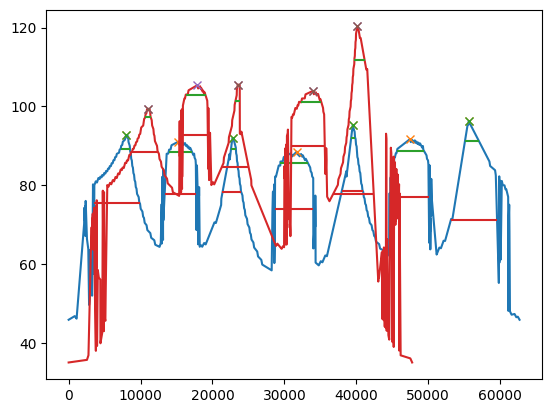

In [48]:
# Identification of the corners using the peaks detected with the polar coordonates
# Exemple of a successful detection and a failed one :

corners = []

# x= range(len(polar_coord))
x = [1, 7]
for i in x:
    rho = polar_coord[i][:, 0]
    theta = polar_coord[i][:, 1]

    # Resamp
    idx = np.argsort(theta)
    theta_resamp = np.arange(theta.min(), theta.max(), 1e-4)
    rho_resamp = np.interp(theta_resamp, theta[idx], rho[idx])

    idx = start_by_min_idx(rho_resamp)
    rho_resamp = rho_resamp[idx]
    theta_resamp = theta_resamp[idx]
    # Find peaks
    peaks, _ = find_peaks(rho_resamp, height=np.percentile(rho_resamp, 50), width=1500, rel_height=0.5)

    top_width = scipy.signal.peak_widths(rho_resamp, peaks, rel_height=0.1)
    middle_width = scipy.signal.peak_widths(rho_resamp, peaks, rel_height=0.5)
    corner_peaks = peaks[np.argsort(top_width[0] / middle_width[0])[:4]]

    plt.plot(rho_resamp)
    plt.plot(peaks, rho_resamp[peaks], "x")
    plt.hlines(*top_width[1:], color="C2")
    plt.hlines(*middle_width[1:], color="C3")
    plt.plot(corner_peaks, rho_resamp[corner_peaks], "x")

    local_corners = []
    for peak in corner_peaks:
        corner_rho = rho_resamp[peak]
        corner_theta = theta_resamp[peak]
        corner_x, corner_y = get_xy_coord(corner_rho, corner_theta, new_centroids[i][0], new_centroids[i][1])
        local_corners.append([corner_x, corner_y])
    corners.append(local_corners)

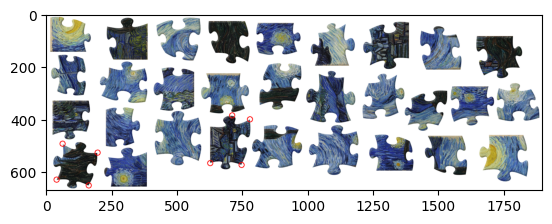

In [47]:
corner_img = img.copy()

for local_corner in corners[:]:
    for corner in local_corner:
        cv2.circle(corner_img, np.array(corner).astype(int), 10, (0, 0, 255), thickness=2)

plot(corner_img)

We see that we don't manage to identify correctly every corner just using the polar coordiantes, as the previous picture shows. 